In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df = pd.read_csv('emotions.txt',names=['sentence','emotions'], sep=';')
df

,sentence,emotions
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


Class 0 : 5362
Class 1 : 4666
Class 2 : 2159
Class 3 : 1937
Class 4 : 1304
Class 5 : 572


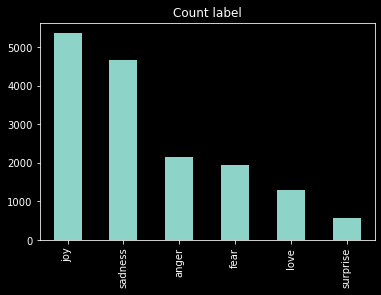

In [3]:
label_count = df['emotions'].value_counts()

for i in range(0,6):
    print(f'Class {i} : {label_count[i]}')

label_count.plot(kind='bar', title='Count label')
plt.show()

Random Over Sampling
joy         5362
sadness     5362
anger       5362
fear        5362
love        5362
surprise    5362
Name: emotions, dtype: int64


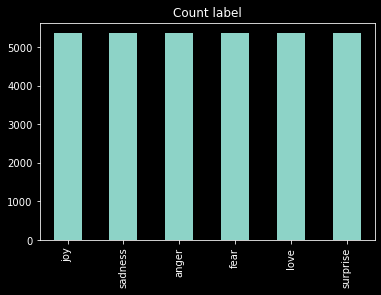

In [4]:
df_class_0 = df[df['emotions'] == 'joy']
df_class_1 = df[df['emotions'] == 'sadness']
df_class_2 = df[df['emotions'] == 'anger']
df_class_3 = df[df['emotions'] == 'fear']
df_class_4 = df[df['emotions'] == 'love']
df_class_5 = df[df['emotions'] == 'surprise']

df_class_1_over = df_class_1.sample(label_count[0], replace=True)
df_class_2_over = df_class_2.sample(label_count[0], replace=True)
df_class_3_over = df_class_3.sample(label_count[0], replace=True)
df_class_4_over = df_class_4.sample(label_count[0], replace=True)
df_class_5_over = df_class_5.sample(label_count[0], replace=True)

df_over = pd.concat([
                    df_class_0,
                    df_class_1_over,
                    df_class_2_over,
                    df_class_3_over,
                    df_class_4_over,
                    df_class_5_over],axis=0)

print('Random Over Sampling')
print(df_over['emotions'].value_counts())
df_over['emotions'].value_counts().plot(kind='bar', title='Count label')
plt.show()

In [5]:
label = pd.get_dummies(df_over['emotions'])
datasets = pd.concat([df_over, label], axis=1)
datasets = datasets.drop(columns='emotions')
datasets

,sentence,anger,fear,joy,love,sadness,surprise
8,i have been with petronas for years i feel tha...,0,0,1,0,0,0
11,i do feel that running is a divine experience ...,0,0,1,0,0,0
14,i have immense sympathy with the general point...,0,0,1,0,0,0
15,i do not feel reassured anxiety is on each side,0,0,1,0,0,0
22,i have the feeling she was amused and delighted,0,0,1,0,0,0
...,...,...,...,...,...,...,...
14107,i feel kind of strange,0,0,0,0,0,1
15825,i even feel it is a game that i am a part of s...,0,0,0,0,0,1
13080,i know i have an international audience but ev...,0,0,0,0,0,1
8244,i just posted when i reached to someones faceb...,0,0,0,0,0,1


In [6]:
label_name = [
    'anger',
    'fear',
    'joy',
    'love',
    'sadness',
    'surprise',
    ]

sentence = datasets['sentence'].values
label = datasets[label_name].values

train_tweet, test_tweet, train_label, test_label = train_test_split(
    sentence, 
    label, 
    test_size=0.2,
    random_state=1,
    )

tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(train_tweet)
tokenizer.fit_on_texts(test_tweet)

train_sequence = tokenizer.texts_to_sequences(train_tweet)
test_sequence = tokenizer.texts_to_sequences(test_tweet)

train_padded = pad_sequences(train_sequence)
test_padded = pad_sequences(test_sequence)

In [7]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy')>0.95):
            self.model.stop_training = True;
            print('\nAkurasi telah melewati 95%')

callbacks = myCallback()

In [8]:
model = Sequential([
    layers.Embedding(input_dim=5000, output_dim=16),
    layers.LSTM(64),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax'),
    ])
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )
hist = model.fit(
    train_padded,
    train_label, 
    epochs=30,
    validation_data=(test_padded, test_label),
    verbose=2,
    callbacks=[callbacks],
    )

Epoch 1/30
805/805 - 81s - loss: 1.2911 - accuracy: 0.4311 - val_loss: 0.7156 - val_accuracy: 0.6926 - 81s/epoch - 101ms/step
Epoch 2/30
805/805 - 72s - loss: 0.5457 - accuracy: 0.8086 - val_loss: 0.2922 - val_accuracy: 0.9049 - 72s/epoch - 89ms/step
Epoch 3/30
805/805 - 71s - loss: 0.2408 - accuracy: 0.9322 - val_loss: 0.1846 - val_accuracy: 0.9495 - 71s/epoch - 88ms/step
Epoch 4/30

Akurasi telah melewati 95%
805/805 - 73s - loss: 0.1464 - accuracy: 0.9597 - val_loss: 0.1733 - val_accuracy: 0.9472 - 73s/epoch - 91ms/step


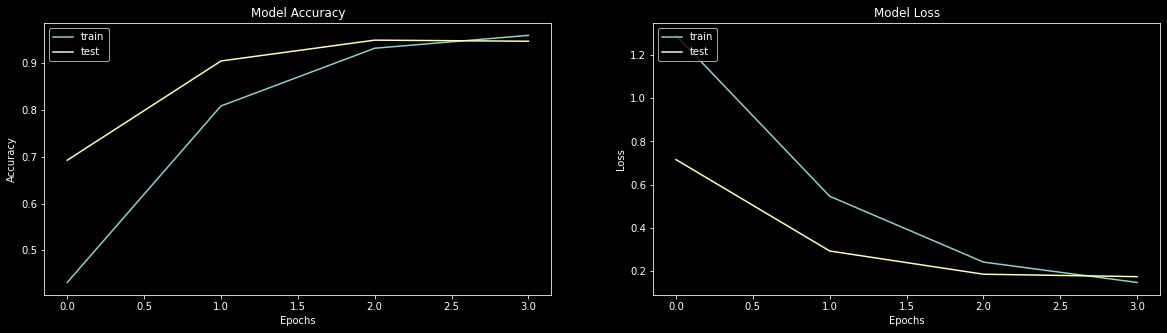

In [9]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')

plt.show()